# Сравнение средних бутстрапированием и методом Манна-Уитни
Сравнить средние между тестом и контролем методом бутстрап и с применением критерия Манна-Уитни

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [5]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/389496/hw_bootstrap.csv',
                sep=';', decimal=',', index_col=0)

In [7]:
treatment = df.query('experimentVariant == "Treatment"').value.reset_index(drop=True)
control = df.query('experimentVariant == "Control"').value.reset_index(drop=True)

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [18]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot=1000, # количество бутстрэп-подвыборок
    statistic=np.mean, # интересующая нас статистика
    alpha=0.05 # уровень значимости
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        # чтобы сохранить дисперсию, берем такой же размер выборки
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        boot_data.append(statistic(samples_1 - samples_2)) 
    
    df = pd.DataFrame(boot_data)
        
    left_quant = alpha / 2 # левый край доверительного интервала
    right_quant = 1 - alpha / 2 # правый край доверительного интервала
    quants = df.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(df[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, color='k', linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### Проверка гипотезы с применением бутстрапа

100%|██████████| 1000/1000 [00:00<00:00, 1935.23it/s]


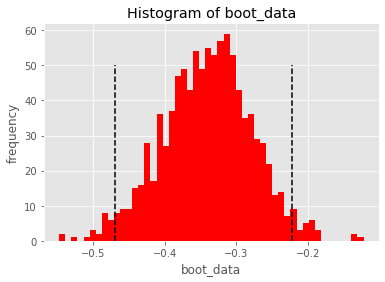

In [19]:
booted_data = get_bootstrap(control, treatment) 

In [10]:
booted_data["p_value"] 

2.1613642918666625e-07

In [11]:
booted_data["quants"] 

,0
0.025,-0.462082
0.975,-0.210996


#### Проверка гипотезы с применением критерия Манна-Уитни

In [12]:
stat, p = mannwhitneyu(control, treatment)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=9508.000, p=0.003


#### Выводы

На основании результатов бутстрап можно сделать вывод, что с вероятностью 95% разница средних между контрольной выборкой и тестовой выборкой лежит в интервале от -0.462082 до -0.210996. Данные значения доверительного интервала позволяют сделать вывод о значимости различий. 
При применении критерия Манна-Уитни был получен p-value=0.003, что также позволяет отклонить нулевую гипотезу о равенственстве средних (p < 0.05).
Таким образом, при применении обоих критериев нулевая гипотеза была отклонена. 
Однако, p-value в бутстрап сильно меньше p-value, полученного u-тестом. Скорее всего, это связано с тем, что критерий Манна-Уитни проверяет гипотезу не равенстве средних значений, а о равенстве распределений, тогда как в бутстрап методе мы сравниваем именно средние значения. Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки.